In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
print(customers.head())
print(products.head())
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [4]:
print(customers.info())
print(products.info())
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------

In [5]:
print(customers.describe())
print(products.describe())
print(transactions.describe())

       CustomerID      CustomerName         Region  SignupDate
count         200               200            200         200
unique        200               200              4         179
top         C0001  Lawrence Carroll  South America  2022-04-16
freq            1                 1             59           3
            Price
count  100.000000
mean   267.551700
std    143.219383
min     16.080000
25%    147.767500
50%    292.875000
75%    397.090000
max    497.760000
          Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000    16.08000
25%       2.000000   295.295000   147.95000
50%       3.000000   588.880000   299.93000
75%       4.000000  1011.660000   404.40000
max       4.000000  1991.040000   497.76000


# EDA Distribution of Product Categories

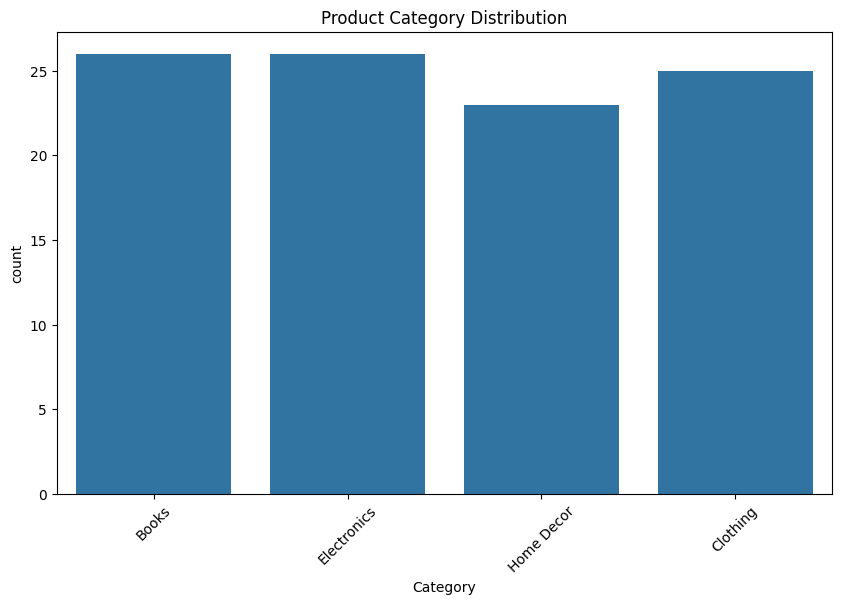

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(data=products, x='Category')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)
plt.show()

# EDA: Region distribution of customers

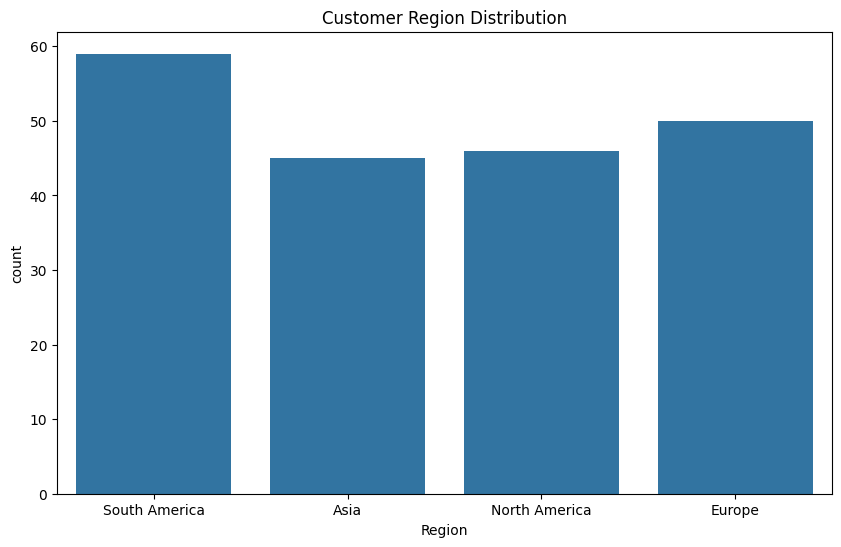

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=customers, x='Region')
plt.title('Customer Region Distribution')
plt.show()


# EDA: Transactions over time

In [8]:
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['YearMonth'] = transactions['TransactionDate'].dt.to_period('M')

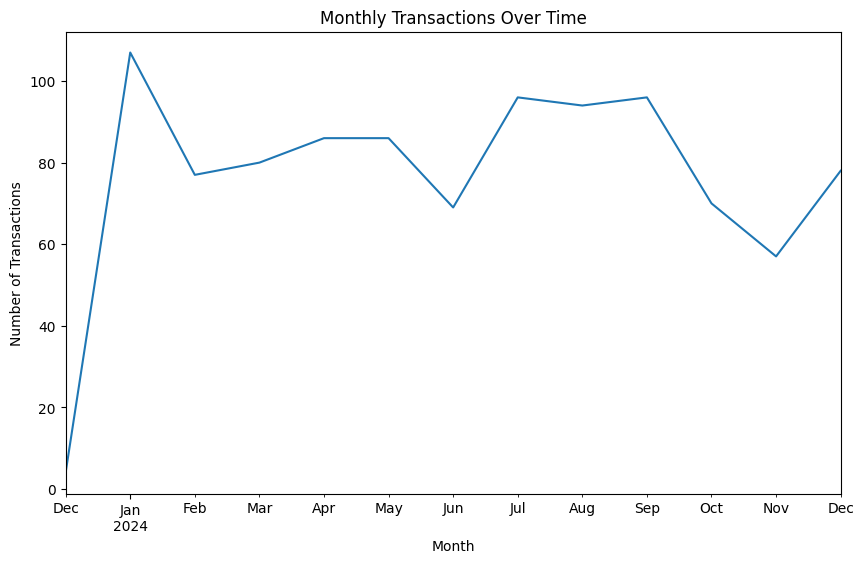

In [9]:
monthly_transactions = transactions.groupby('YearMonth').size()
monthly_transactions.plot(kind='line', figsize=(10, 6))
plt.title('Monthly Transactions Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

# EDA: Total value by customer

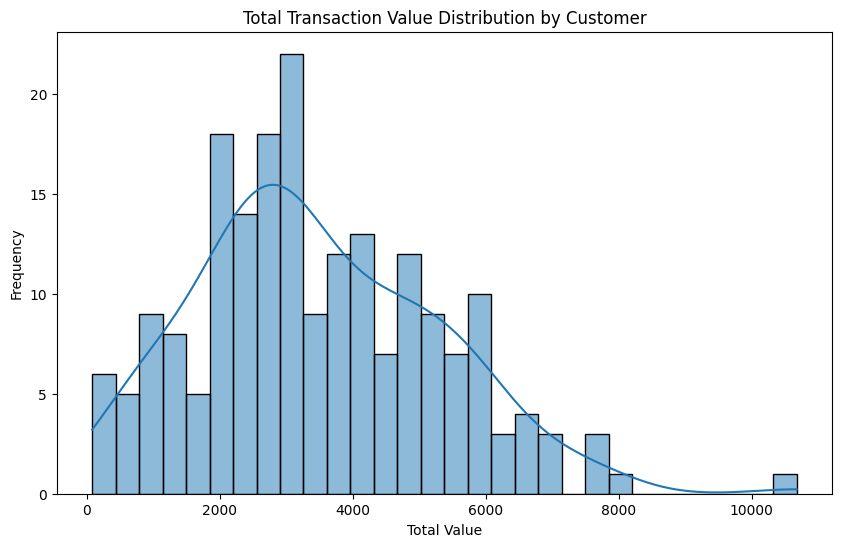

In [10]:
total_value_by_customer = transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.histplot(total_value_by_customer['TotalValue'], bins=30, kde=True)
plt.title('Total Transaction Value Distribution by Customer')
plt.xlabel('Total Value')
plt.ylabel('Frequency')
plt.show()

# Lookalike Model

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [12]:
customer_data = customers.merge(transactions, on='CustomerID', how='inner')
customer_product_data = customer_data.groupby(['CustomerID', 'ProductID'])['Quantity'].sum().unstack(fill_value=0)

In [13]:
scaler = StandardScaler()
customer_product_data_scaled = scaler.fit_transform(customer_product_data)

In [14]:
similarity_matrix = cosine_similarity(customer_product_data_scaled)

In [15]:
def get_top_lookalikes(customer_id, similarity_matrix, top_n=3):
    customer_idx = customer_product_data.index.get_loc(customer_id)
    similarity_scores = similarity_matrix[customer_idx]

In [18]:

    similar_customers = sorted(
        list(enumerate(similarity_scores)), key=lambda x: x[1], reverse=True
    )
    
    top_lookalikes = [(customer_product_data.index[i], score) for i, score in similar_customers[1:top_n+1]]
    
    return top_lookalikes

lookalike_results = {}

for customer_id in customer_product_data.index[:20]:
    lookalikes = get_top_lookalikes(customer_id, similarity_matrix)
    lookalike_results[customer_id] = [lookalike[0] for lookalike in lookalikes] + [lookalike[1] for lookalike in lookalikes]

columns = ['Lookalike_1', 'Lookalike_2', 'Lookalike_3', 'Score_1', 'Score_2', 'Score_3']
lookalike_df = pd.DataFrame.from_dict(lookalike_results, orient='index', columns=columns)
lookalike_df.to_csv('Lookalike.csv')

print(lookalike_df.head())


      Lookalike_1 Lookalike_2 Lookalike_3   Score_1   Score_2   Score_3
C0001       C0194       C0104       C0020  0.404928  0.374002  0.366609
C0002       C0030       C0091       C0071  0.404617  0.383778  0.320158
C0003       C0181       C0134       C0144  0.477572  0.471016  0.423800
C0004       C0070       C0175       C0132  0.351901  0.316098  0.279599
C0005       C0096       C0023       C0055  0.487456  0.470252  0.382100


#  Customer Segmentation / Clustering

In [19]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score

In [20]:
customer_transactions = customers.merge(transactions, on='CustomerID', how='inner')
customer_profile = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
}).reset_index()

In [21]:
customer_profile_scaled = scaler.fit_transform(customer_profile[['TotalValue', 'Quantity']])

In [22]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(customer_profile_scaled)

In [23]:
db_index = davies_bouldin_score(customer_profile_scaled, customer_profile['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 0.72127971818163


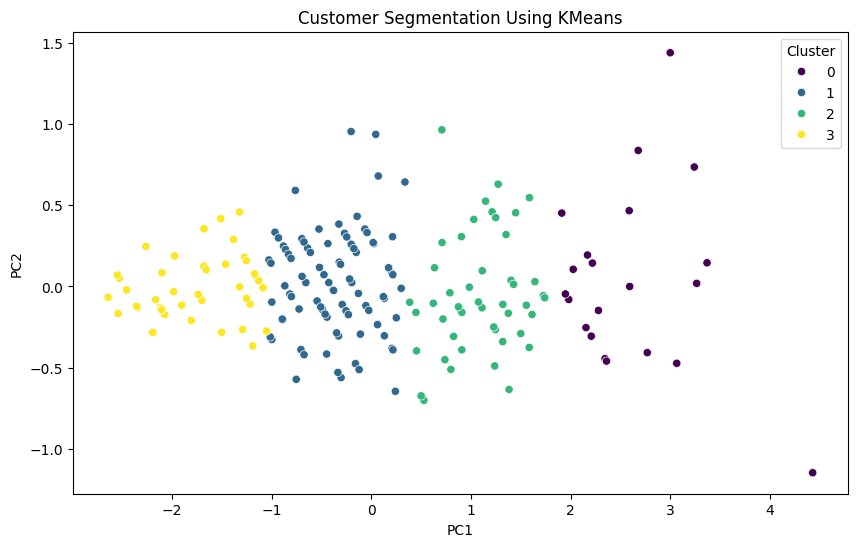

In [24]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(customer_profile_scaled)
customer_profile['PC1'], customer_profile['PC2'] = principal_components[:, 0], principal_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=customer_profile, palette='viridis')
plt.title('Customer Segmentation Using KMeans')
plt.show()

In [25]:
customer_profile[['CustomerID', 'Cluster']].to_csv('Clustering.csv', index=False)